# Assessment 1

## Task 1: Regression

In [1]:
# TensorFlow config to GPU
import tensorflow as tf
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus: 
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=15292)]
    )

logical_gpus = tf.config.list_logical_devices('GPU')
print(logical_gpus)
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")


from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

print()
print()

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.6.0
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
1 Physical GPU, 1 Logical GPUs
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2090261792891546744
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16034824192
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5913532685654759661
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


Num GPUs Available:  1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

# Test Train Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Build Model
from sklearn.linear_model import Lasso

# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score

### Data
This data contains percentage of body fat, age, weight, height, and ten body circumferencemeasurements of 252 men. The purpose of this experiment is to explore if it would be possible to fitbody fat to other measurements using multiple regression, which could provide a convenient way ofestimating body fat for men using only a scale and a measuring tape.

In [3]:
df = pd.read_csv('body_fat_data.csv')
df.shape

(252, 18)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 18 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   Unnamed: 0                                                                       252 non-null    int64  
 1   Percent body fat using Siri equation 495/Density                                 252 non-null    float64
 2   Density gm/cm^3                                                                  252 non-null    float64
 3   Age                                                                              252 non-null    int64  
 4   Weight (lbs)                                                                     252 non-null    float64
 5   Height (inches)                                                                  252 non-null    float64
 6   Adiposity 

As you can see, there are 252 rows and 18 columns in the data. The first column is the index column, in our case is not necessary. The second column is the percentage of body fat, which is the target variable. The rest of the columns are the predictors. The predictors are age, weight, height, Adioposity, Fat Free Weight, Neck circumference, Chest circumference, Abdomen circumference, Hip circumference, Thigh circumference, Knee circumference, Ankle circumference, Biceps circumference, Forearm circumference and Wrist circumference.

In [5]:
# Removing the first column and renaming the columns to make it easier to work with
df = df.iloc[: , 1:]

df.rename(columns={'Percent body fat using Siri equation 495/Density': 'BodyFat',
                   'Density gm/cm^3': 'Density',
                  'Weight (lbs)': 'Weight',
                  'Height (inches)': 'Height',
                  'Adiposity index = Weight/Height^2 (kg/m^2)' : 'AdiposityIndex',
                 'Fat Free Weight (1 - fraction of body fat) * Weight, using Brozek formula (lbs)': 'FatFreeWeight',
                  'Neck circumference (cm)': 'Neck',
                   'Chest circumference (cm)': 'Chest',
                   'Abdomen circumference (cm)': 'Abdomen',
                   'Hip circumference (cm)': 'Hip',
                   'Thigh circumference (cm)': 'Thigh',
                   'Knee circumference (cm)': 'Knee',
                   'Ankle circumference (cm)': 'Ankle',
                   'Extended biceps circumference (cm)': 'ExtendedBiceps',
                   'Forearm circumference (cm)': 'Forearm',
                   'Wrist circumference (cm)': 'Wrist'
                  }, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BodyFat         252 non-null    float64
 1   Density         252 non-null    float64
 2   Age             252 non-null    int64  
 3   Weight          252 non-null    float64
 4   Height          252 non-null    float64
 5   AdiposityIndex  252 non-null    float64
 6   FatFreeWeight   252 non-null    float64
 7   Neck            252 non-null    float64
 8   Chest           252 non-null    float64
 9   Abdomen         252 non-null    float64
 10  Hip             252 non-null    float64
 11  Thigh           252 non-null    float64
 12  Knee            252 non-null    float64
 13  Ankle           252 non-null    float64
 14  ExtendedBiceps  252 non-null    float64
 15  Forearm         252 non-null    float64
 16  Wrist           252 non-null    float64
dtypes: float64(16), int64(1)
memory usa

In [7]:
df.shape

(252, 17)

In [8]:
df.head()

,BodyFat,Density,Age,Weight,Height,AdiposityIndex,FatFreeWeight,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,ExtendedBiceps,Forearm,Wrist
0,12.3,1.0708,23,154.25,67.75,23.7,134.9,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,1.0853,22,173.25,72.25,23.4,161.3,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,1.0414,22,154.00,66.25,24.7,116.0,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,1.0751,26,184.75,72.25,24.9,164.7,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,1.0340,24,184.25,71.25,25.6,133.1,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [9]:
df.describe()

,BodyFat,Density,Age,Weight,Height,AdiposityIndex,FatFreeWeight,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,ExtendedBiceps,Forearm,Wrist
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,19.150794,1.055574,44.884921,178.924405,70.148810,25.436905,143.713889,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,8.368740,0.019031,12.602040,29.389160,3.662856,3.648111,18.231642,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,0.000000,0.995000,22.000000,118.500000,29.500000,18.100000,105.900000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,12.475000,1.041400,35.750000,159.000000,68.250000,23.100000,131.350000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,19.200000,1.054900,43.000000,176.500000,70.000000,25.050000,141.550000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,25.300000,1.070400,54.000000,197.000000,72.250000,27.325000,153.875000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,47.500000,1.108900,81.000000,363.150000,77.750000,48.900000,240.500000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


In [10]:
df.isnull().sum()

BodyFat           0
Density           0
Age               0
Weight            0
Height            0
AdiposityIndex    0
FatFreeWeight     0
Neck              0
Chest             0
Abdomen           0
Hip               0
Thigh             0
Knee              0
Ankle             0
ExtendedBiceps    0
Forearm           0
Wrist             0
dtype: int64

There are no missing values in the data. The data is already cleaned but the predictors are not scaled. You need to scale the predictors before you fit the model.

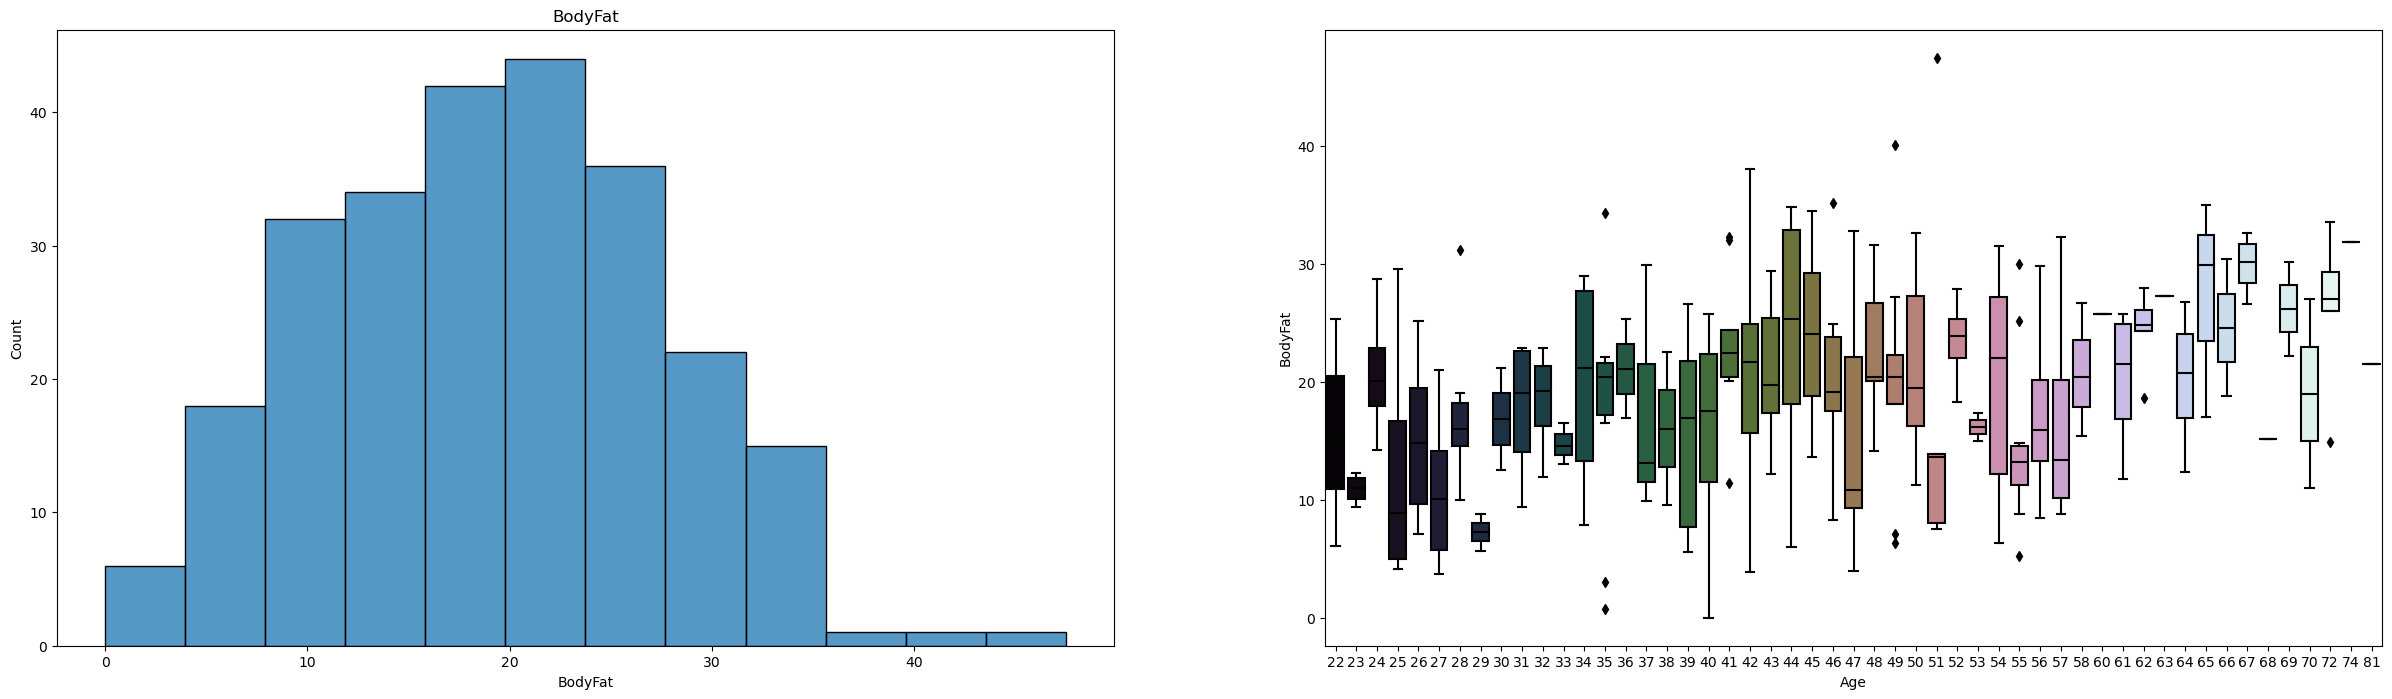

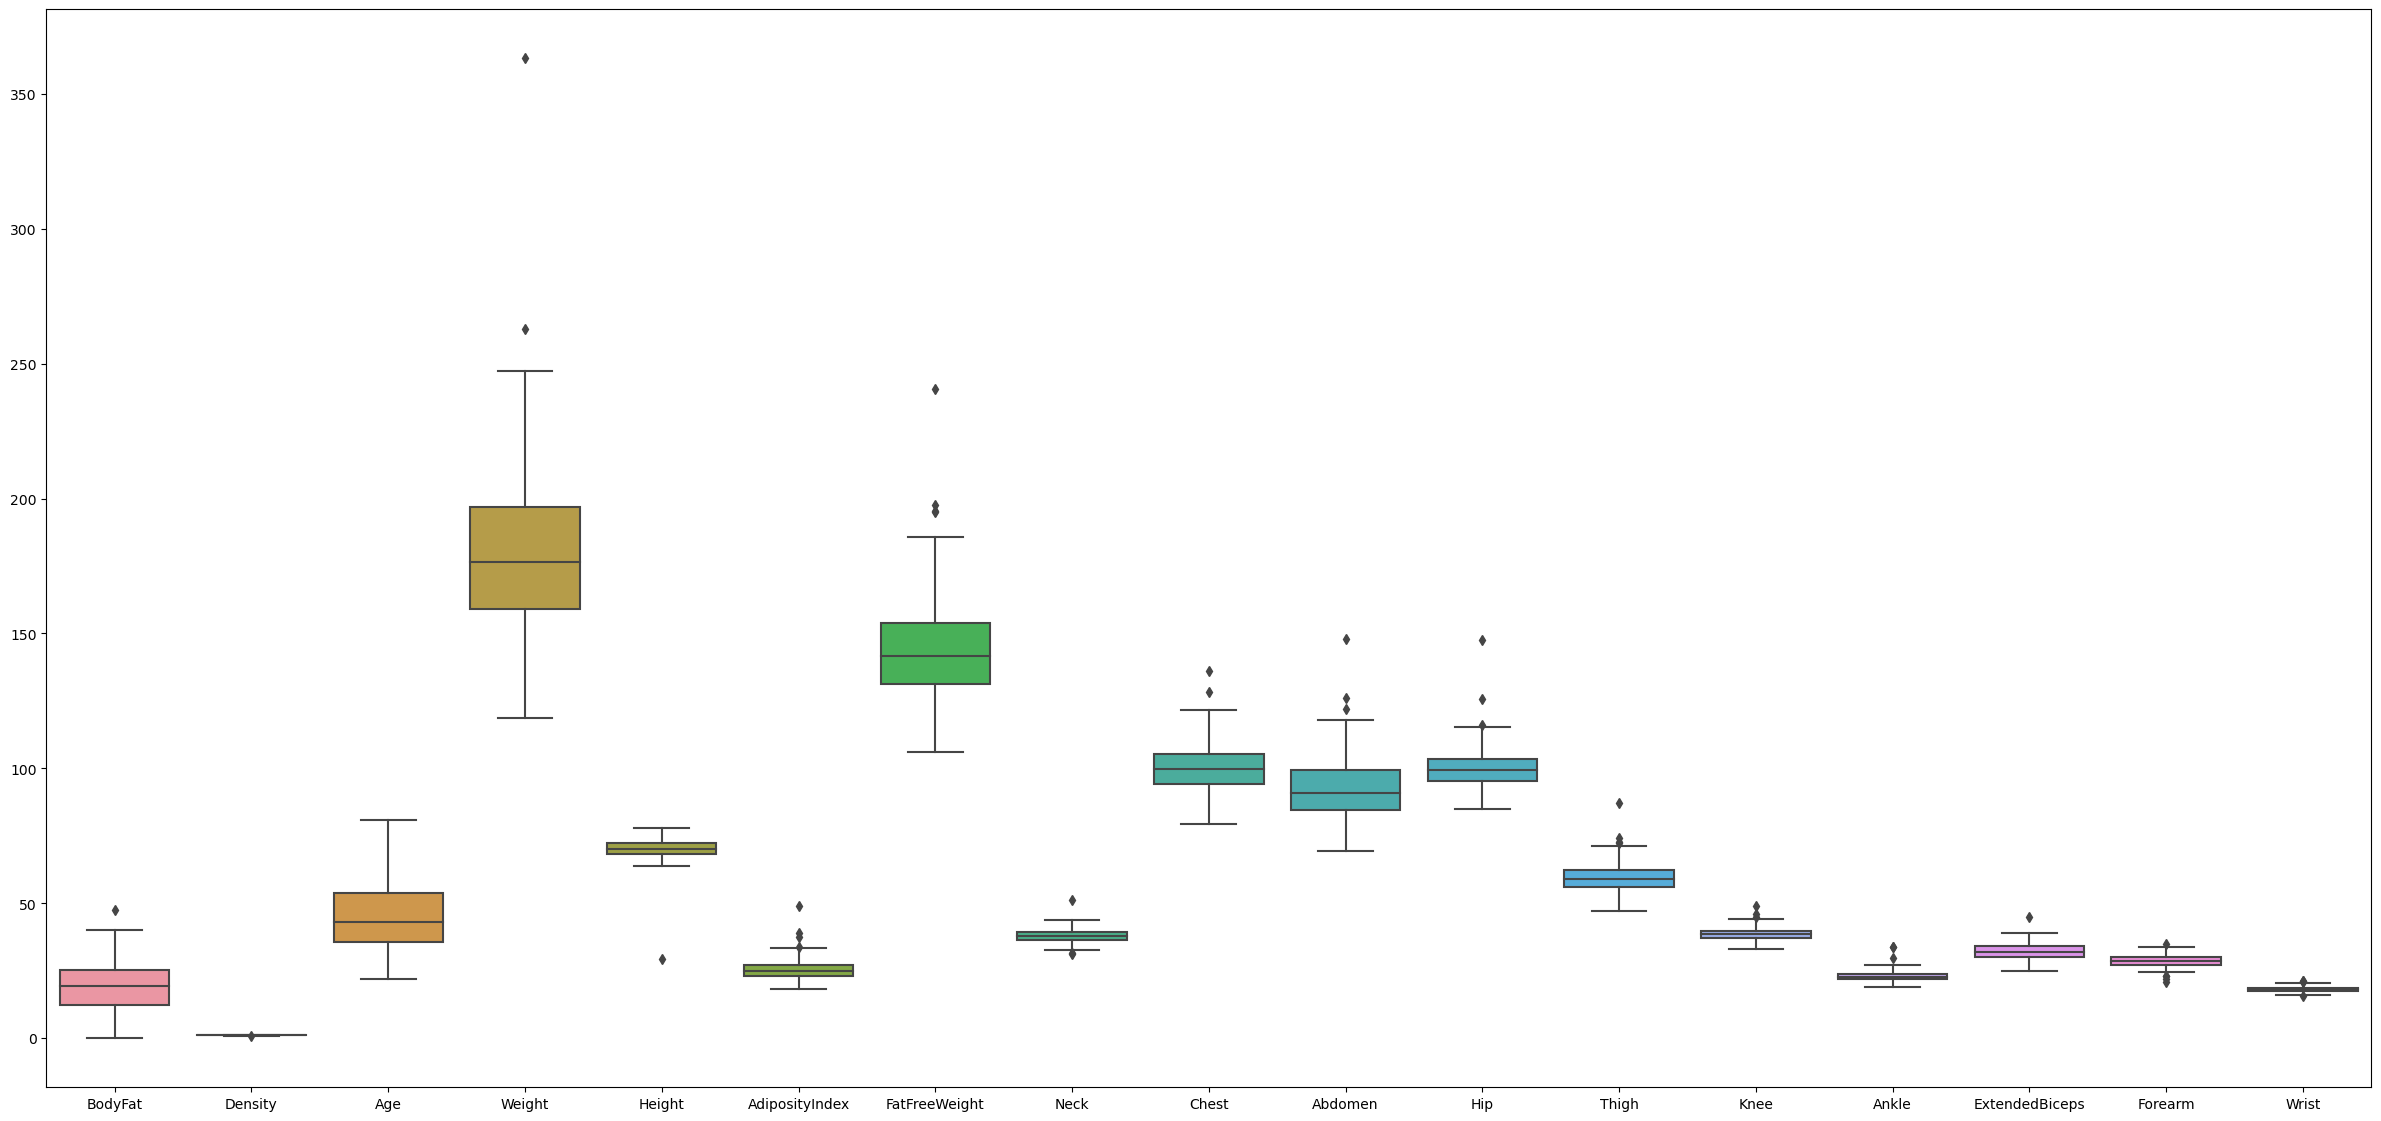

In [11]:
# Data Visualization
plt.figure(figsize=(30,8))

plt.subplot(1,2,1)
plt.title('BodyFat')
sns.histplot(df.BodyFat)

plt.subplot(1,2,2)
sns.boxplot(x=df.Age, y=df.BodyFat, palette=("cubehelix"))

plt.figure(figsize=(30,14))
sns.boxplot(data=df)
plt.show()

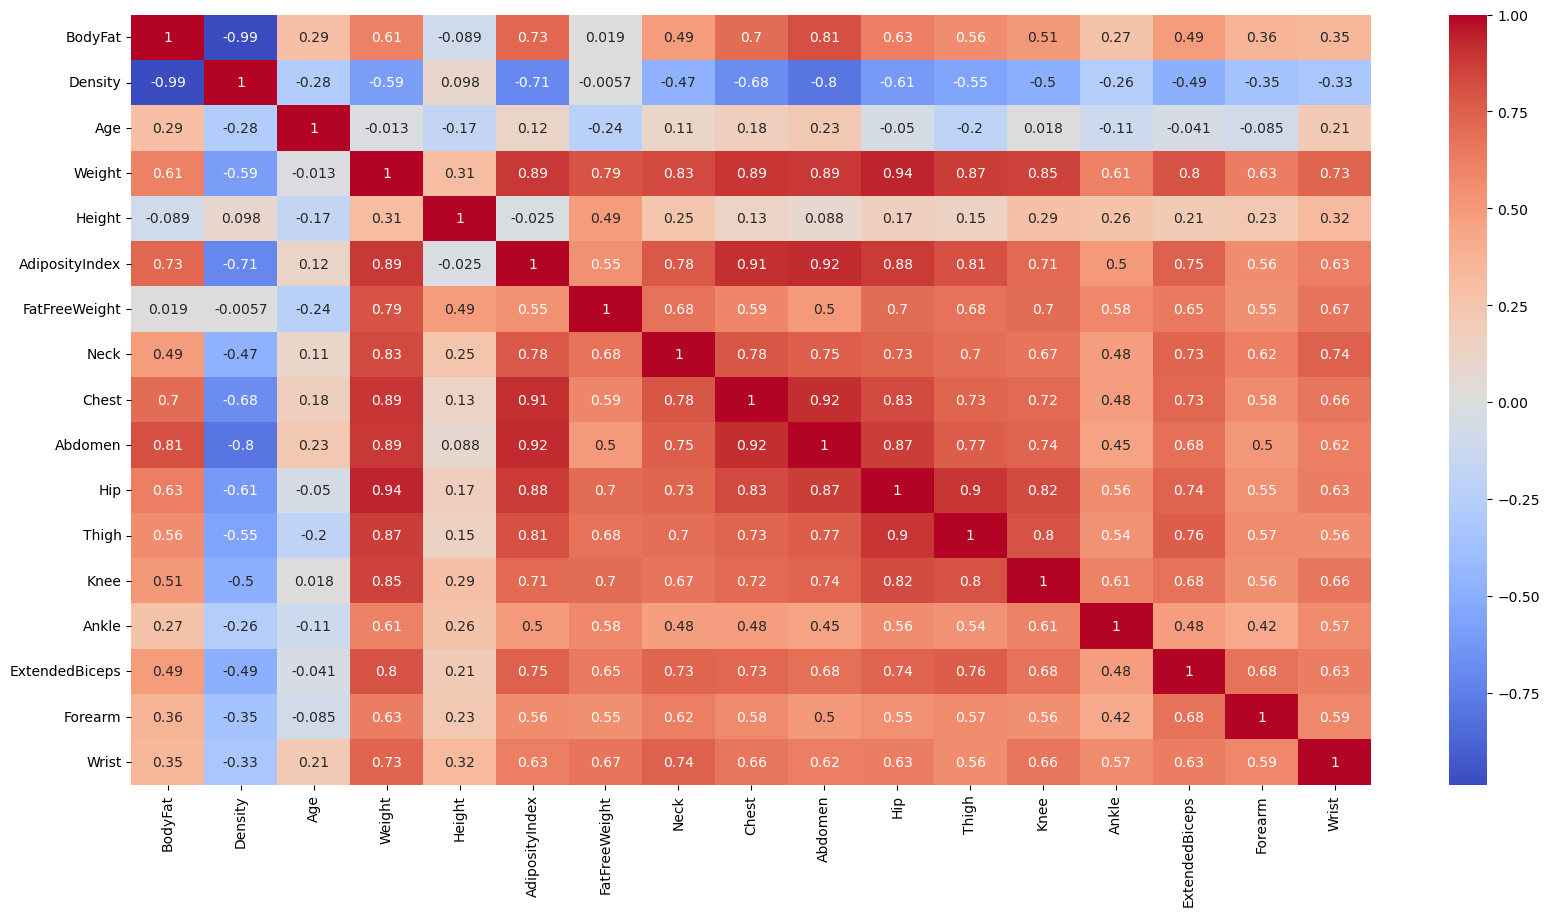

In [12]:
# Getting the correlation matrix
corr = df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [13]:
# Creating X and y
X = df.drop('BodyFat',axis=1)
y = df['BodyFat']

In [14]:
X

,Density,Age,Weight,Height,AdiposityIndex,FatFreeWeight,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,ExtendedBiceps,Forearm,Wrist
0,1.0708,23,154.25,67.75,23.7,134.9,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,22,173.25,72.25,23.4,161.3,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,22,154.00,66.25,24.7,116.0,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,26,184.75,72.25,24.9,164.7,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,24,184.25,71.25,25.6,133.1,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,70,134.25,67.00,21.1,118.9,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5
248,1.0236,72,201.00,69.75,29.1,136.1,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1
249,1.0328,72,186.75,66.00,30.2,133.9,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0
250,1.0399,72,190.75,70.50,27.0,142.6,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8


In [15]:
y

0      12.3
1       6.1
2      25.3
3      10.4
4      28.7
       ... 
247    11.0
248    33.6
249    29.3
250    26.0
251    31.9
Name: BodyFat, Length: 252, dtype: float64

In [16]:
# Standardize the data
scaler = StandardScaler()

X = normalize(X)
X = scaler.fit_transform(X)
# convert y to numpy array
y = np.array(y)

In [17]:
y

array([12.3,  6.1, 25.3, 10.4, 28.7, 20.9, 19.2, 12.4,  4.1, 11.7,  7.1,
        7.8, 20.8, 21.2, 22.1, 20.9, 29. , 22.9, 16. , 16.5, 19.1, 15.2,
       15.6, 17.7, 14. ,  3.7,  7.9, 22.9,  3.7,  8.8, 11.9,  5.7, 11.8,
       21.3, 32.3, 40.1, 24.2, 28.4, 35.2, 32.6, 34.5, 32.9, 31.6, 32. ,
        7.7, 13.9, 10.8,  5.6, 13.6,  4. , 10.2,  6.6,  8. ,  6.3,  3.9,
       22.6, 20.4, 28. , 31.5, 24.6, 26.1, 29.8, 30.7, 25.8, 32.3, 30. ,
       21.5, 13.8,  6.3, 12.9, 24.3,  8.8,  8.5, 13.5, 11.8, 18.5,  8.8,
       22.2, 21.5, 18.8, 31.4, 26.8, 18.4, 27. , 27. , 26.6, 14.9, 23.1,
        8.3, 14.1, 20.5, 18.2,  8.5, 24.9,  9. , 17.4,  9.6, 11.3, 17.8,
       22.2, 21.2, 20.4, 20.1, 22.3, 25.4, 18. , 19.3, 18.3, 17.3, 21.4,
       19.7, 28. , 22.1, 21.3, 26.7, 16.7, 20.1, 13.9, 25.8, 18.1, 27.9,
       25.3, 14.7, 16. , 13.8, 17.5, 27.2, 17.4, 20.8, 14.9, 18.1, 22.7,
       23.6, 26.1, 24.4, 27.1, 21.8, 29.4, 22.4, 20.4, 24.9, 18.3, 23.3,
        9.4, 10.3, 14.2, 19.2, 29.6,  5.3, 25.2,  9

When we have multiple feaures having various degrees of magnitude, range, units and other statistical properties, it is a good practice to scale the features so that they can be uniformly evaluated. This is called feature scaling. There are many ways to scale the features. In this task, you will use the standardization method to scale the features. The standardization method subtracts the mean from each value and then divides the difference by the standard deviation. The result is a feature that has a mean of 0 and a standard deviation of 1.

In [18]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train.shape

(201,)

In [19]:
# Using Lasso Regression
lasso = Lasso(alpha=10)
lasso.fit(X_train, y_train)

# Predicting the test set
y_pred = lasso.predict(X_test)

# Evaluating the model
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))

Mean Squared Error: 48.50157579093122
R2 Score: -0.04263946932861762


For this task, we will use multiple linear regression to predict the percentage of body fat. More specifically, we will use Laso regression to fit the model. The reason we use Laso regression is that it can automatically select the most important features and remove the less important features. This is very useful when we have a lot of features and we want to reduce the dimensionality of the data.

From the above cell, we can see that for different alpha values, we get different MSE and R2 values. The MSE and R2 values are the performance metrics of the model. The MSE is the mean squared error, which is the average of the squared differences between the target and the prediction. The R2 is the coefficient of determination, which is a statistical measure of how well the regression predictions approximate the real data points. The R2 value is between 0 and 1. The higher the R2 value, the better the model fits the data.

To find the best alpha (the hyper parameter of the model), we can use the cross validation method. The cross validation method splits the data into k folds. For each fold, we train the model on the rest of the data and evaluate the model on the fold. We repeat this process k times and get k MSE and R2 values. The average of the k MSE and R2 values is the average MSE and R2 values. The hyper parameter that gives the best average MSE and R2 values is the best hyper parameter.

In [20]:
# Using K-Fold Cross Validation
def train_cv(X_sub, y_sub, n_splits=5, shuffle=True):
    k_fold = KFold(n_splits = n_splits, shuffle=shuffle)
    k_fold.get_n_splits(X_sub)
    curr_alpha = 0.00001 #### 0.00001 -> 1
    alpha_list = []
    MSE = []
    for train_index, test_index in k_fold.split(X_sub):
        X_train_sub, X_test_sub = X_sub[train_index], X_sub[test_index]
        y_train_sub, y_test_sub = y_sub[train_index], y_sub[test_index]

        # create a Lasso object
        reg_model = Lasso()

        # get each alpha value and train the model
        while curr_alpha <= 1:
            reg_model.set_params(alpha=curr_alpha)
            alpha_list.append(curr_alpha) # [0.00001, 0.00002, 0.00003 ..., 1]
            reg_model.fit(X_train_sub, y_train_sub)
            y_pred_sub = reg_model.predict(X_test_sub)
            MSE.append(mean_squared_error(y_test_sub, y_pred_sub))
            # print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
            curr_alpha += 0.00001
    return MSE, alpha_list

In [21]:
mse, alpha = train_cv(X_train,y_train)

Now we have our mean squared error and R2 values for different alpha values. We can plot the mean squared error and R2 values against the alpha values. The plot will show us the best alpha value.

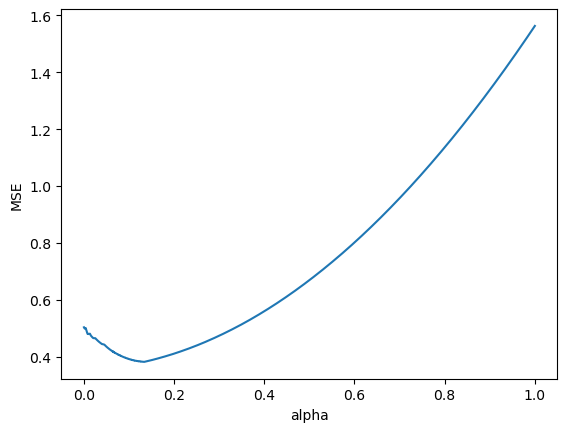

In [22]:
# plot the MSE values for each alpha value
plt.plot(alpha, mse)
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.show()

In [23]:
# Finding the best alpha value
min_mse = min(mse)
best_alpha = alpha[mse.index(min_mse)]
print('Best alpha value:', best_alpha)

Best alpha value: 0.13322999999999247


In [24]:
# create a lasso regression with alpha value = best_alpha

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_test, y_test, test_size=0.9, random_state=42)

reg_model = Lasso(alpha=best_alpha)
reg_model.fit(X_train, y_train)
y_pred_new = reg_model.predict(X_test2)

print(reg_model.alpha)

# print the mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test2, y_pred_new))

# print the R2 score
print('R2 score: %.2f' % r2_score(y_test2, y_pred_new))

0.13322999999999247
Mean squared error: 0.35
R2 score: 0.99


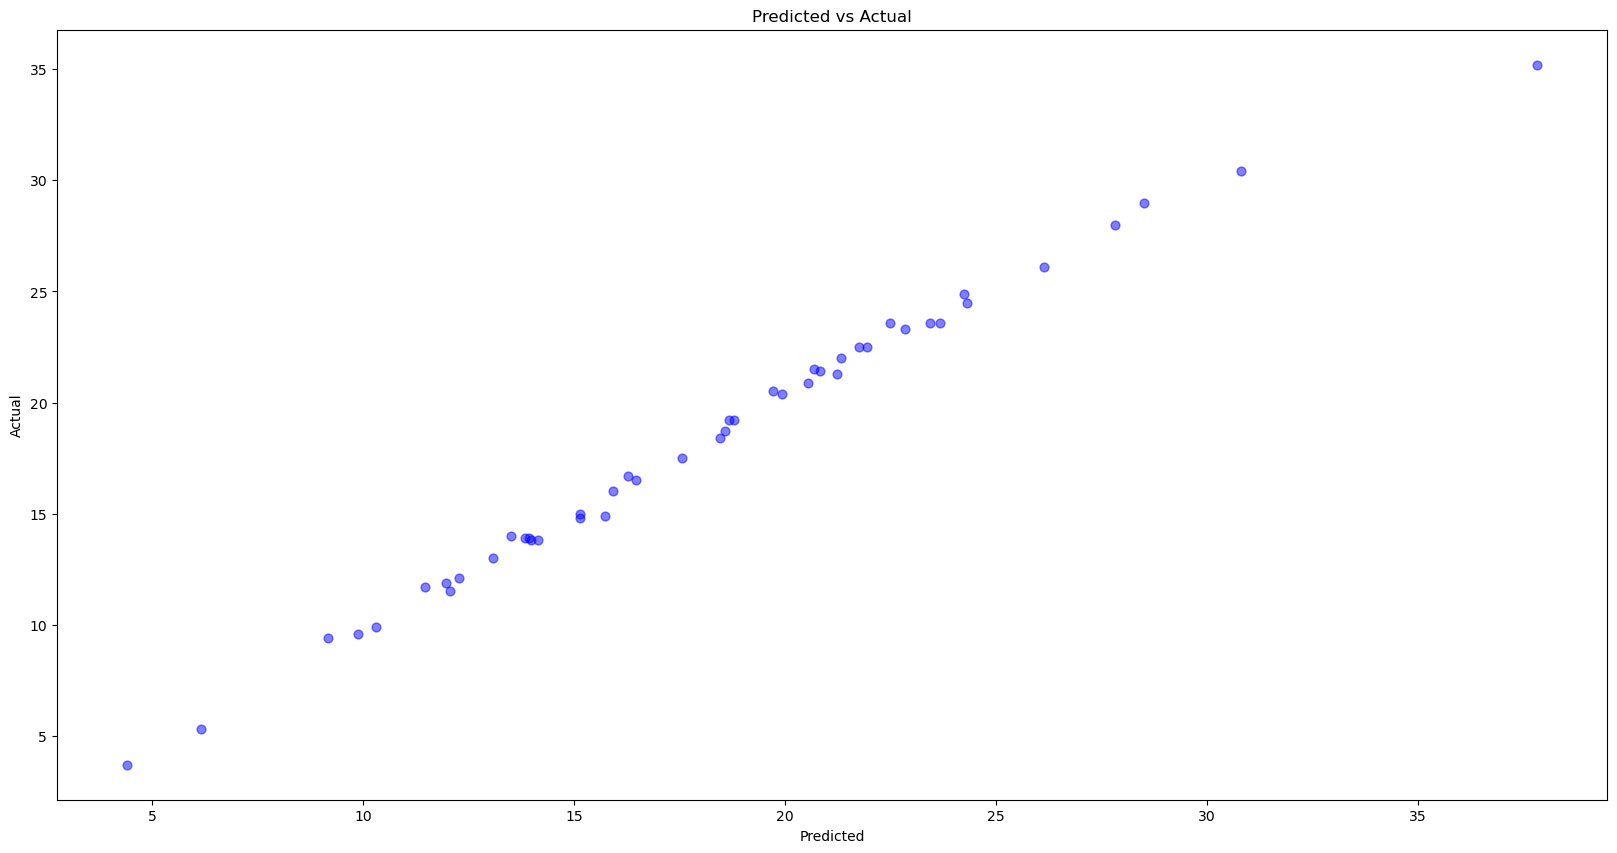

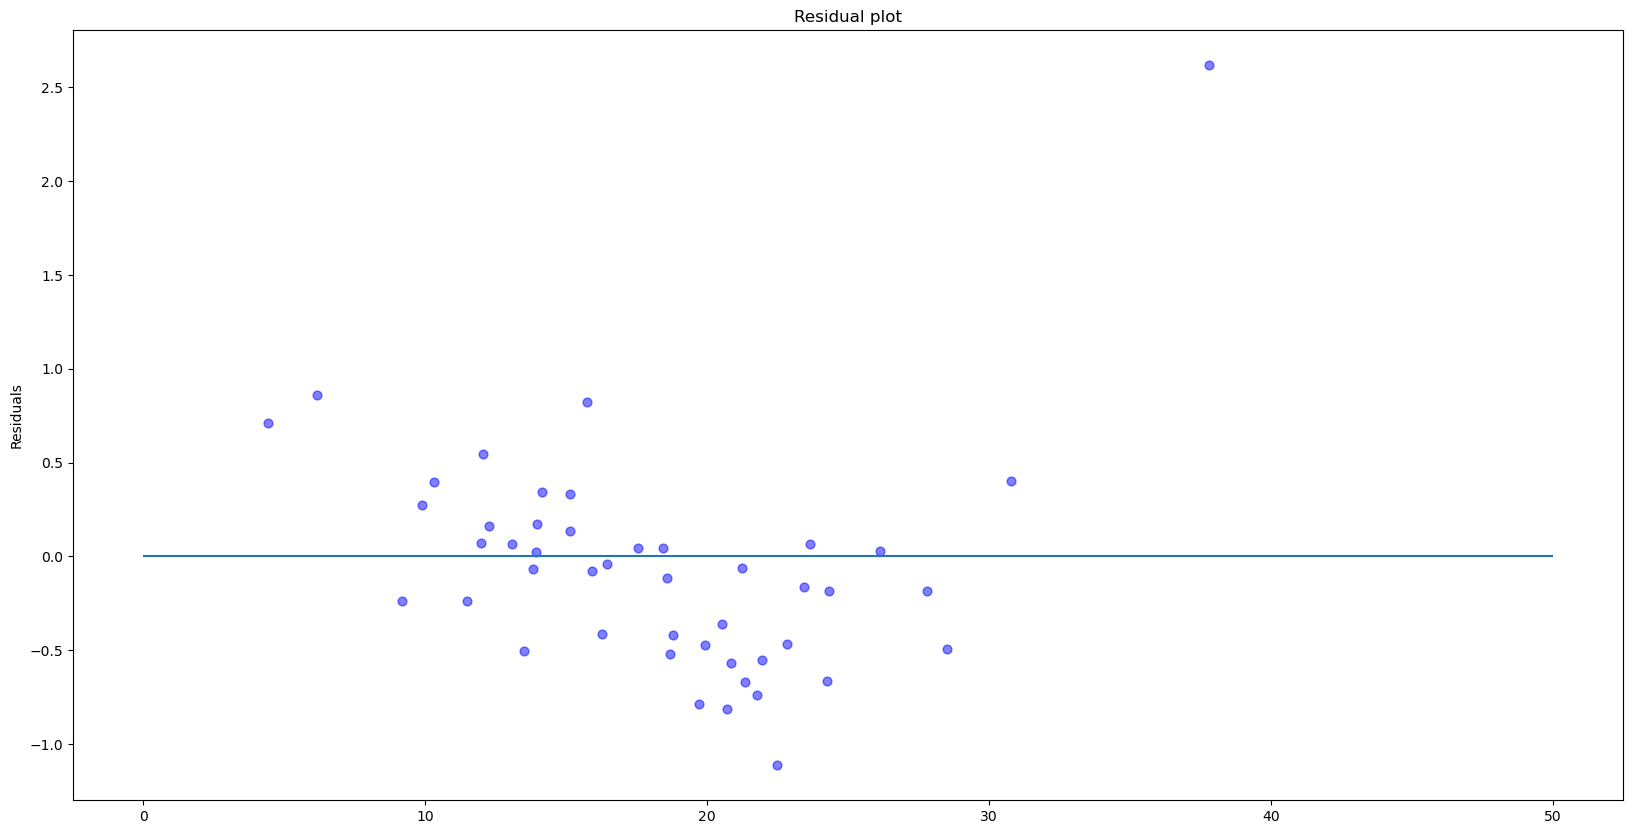

In [62]:
# Plotting the predicted values vs the actual values
plt.figure(figsize=(20,10))
plt.scatter(y_pred_new, y_test2, c='b', s=40, alpha=0.5)
plt.title('Predicted vs Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plotting the residuals
plt.figure(figsize=(20,10))
plt.scatter(y_pred_new, y_pred_new - y_test2, c='b', s=40, alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=50)
plt.title('Residual plot')
plt.ylabel('Residuals')
plt.show()

In [63]:
df_re = df.drop('BodyFat',axis=1)
list(df_re.columns)

['Density',
 'Age',
 'Weight',
 'Height',
 'AdiposityIndex',
 'FatFreeWeight',
 'Neck',
 'Chest',
 'Abdomen',
 'Hip',
 'Thigh',
 'Knee',
 'Ankle',
 'ExtendedBiceps',
 'Forearm',
 'Wrist']

In [64]:
np.array(df_re.columns)[np.abs(reg_model.coef_) > 0]

array(['Density', 'Weight', 'FatFreeWeight', 'Abdomen'], dtype=object)

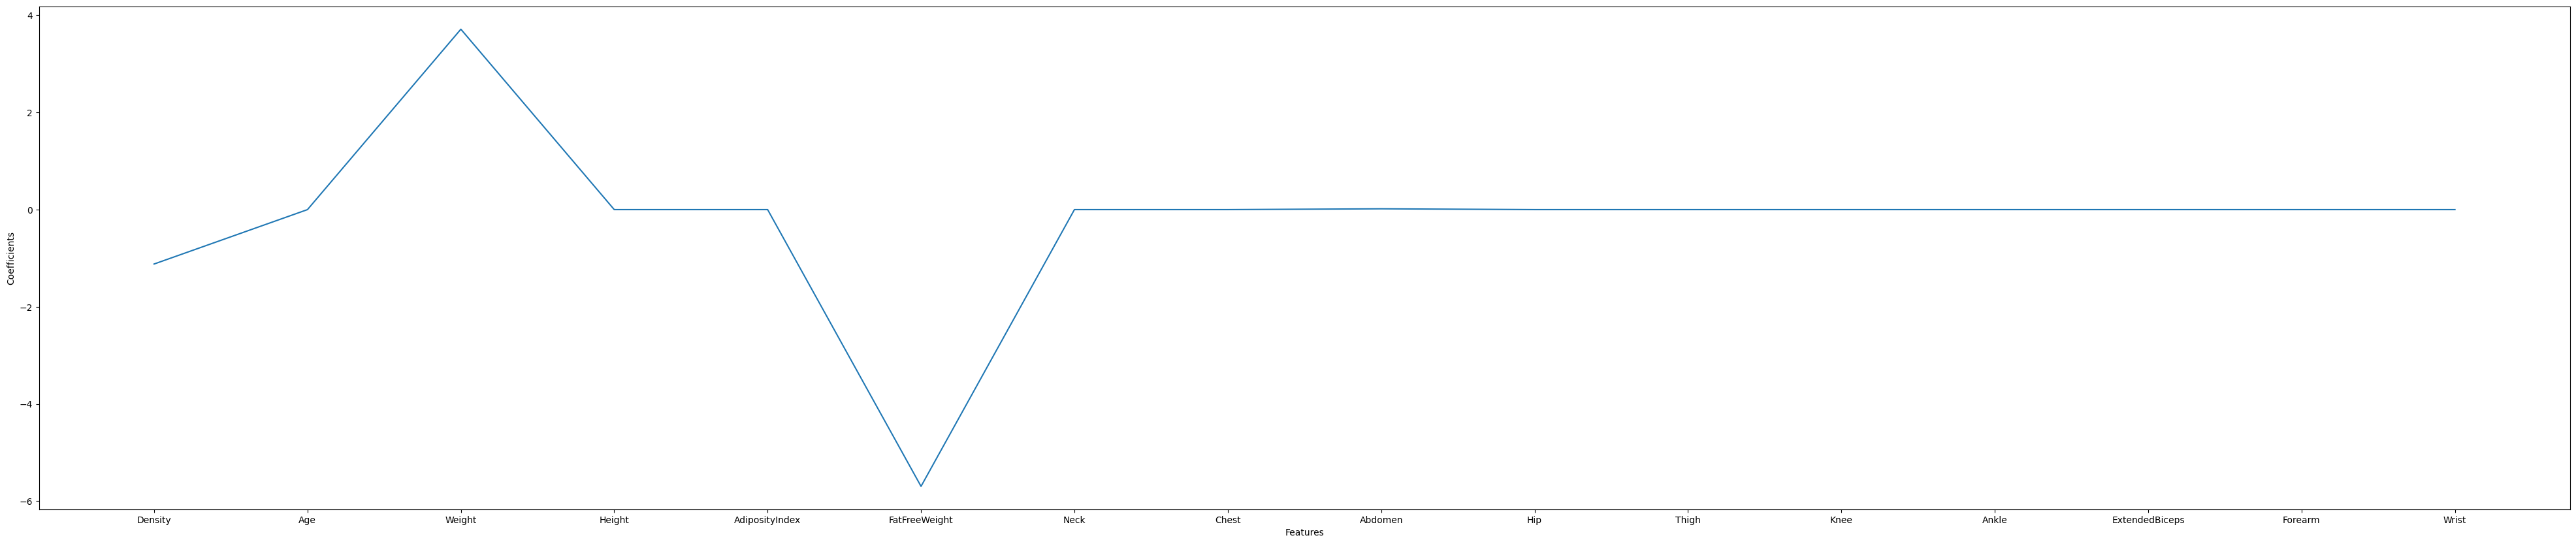

In [65]:
# Plotting the coefficients
plt.figure(figsize=(50,10))
plt.plot(np.array(df_re.columns), reg_model.coef_)
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.show()

Features with the highest absolute coefficients are the most important features. The most important features are 'Density', 'Weight', 'FatFreeWeight', 'Abdomen'. The least important features are the ones with the lowest absolute coefficients.

- Density is the density of the body. The higher the density, the higher the percentage of body fat. 
- Weight is the weight of the body. The higher the weight, the higher the percentage of body fat. 
- FatFreeWeight is the weight of the body without fat. The higher the FatFreeWeight, the higher the percentage of body fat. 
- Abdomen is the circumference of the abdomen. The higher the Abdomen, the higher the percentage of body fat.

After FatFreeWeight, the remaining features seems to have common trend. But when we look at the coefficients, we can see that the coefficient of Abdomen seems above zero. Lets check.

In [69]:
# coefficients of abdomen
reg_model.coef_[df_re.columns.get_loc('Abdomen')]

0.016549619847761304

In [70]:
# coefficients of Thigh
reg_model.coef_[df_re.columns.get_loc('Thigh')]

0.0

Thus we can say that Density, Weight, FatFreeWeight and Abdomen are the most important features. These features affect the percentage of body fat the most.

<b><center>** ---------------------------------------------------------------------------- **</center></b>